# Prac 4

## Q1 k-means clustering algorithm
对高权重数据集(第二列和第三列)应用k-means聚类算法(在Matlab中实现)。将得到的集群中心与数据一起绘制。根据类别标签(第一列;提示:对数据排序!)上色

In [1]:
import scipy.io
import numpy as np

In [7]:
data = scipy.io.loadmat('heightWeight.mat')
# data数据为[1/2, 身高, 体重]
data = data['heightWeightData']
# data_xy是[身高,体重]
data_xy = data[:,1:]


In [8]:
def naiveKmeans(data, k, epsilon = 0.1):
    data_min = np.min(data, axis=0)
    data_max = np.max(data, axis=0)
    assert len(data.shape) == 2
    centroids = np.random.uniform(data_min, data_max,size=(k,data.shape[1]))
    while 1: 
        dists = []
        for center in range(k):
            distances = np.linalg.norm(data-centroids[center,:], axis=1)
            dists.append(distances)
        dists = np.array(dists)
        clusters = np.argmin(dists, axis=0)
        diffs = []
        for center in range(k):
            new_centroid = np.mean(data_xy[clusters==center],axis=0)
            diff = new_centroid - centroids[center,:]
            centroids[center,:] = new_centroid
            diffs.append(diff)
        diffs = np.array(diffs)
        if (diffs < epsilon).all():
            return centroids  
    

In [12]:
means = naiveKmeans(data_xy,2, epsilon=0.001)

labels= data[:,0]
data1 = data_xy[labels==1]
data2 = data_xy[labels==2]

In [10]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 

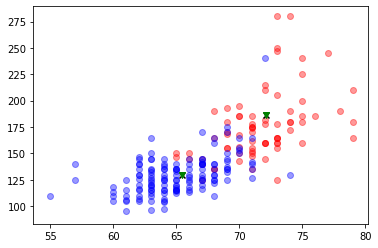

In [13]:
km = KMeans(2).fit(data_xy)

plt.scatter(data1[:,0],data1[:,1], c='r', alpha=0.4)
plt.scatter(data2[:,0],data2[:,1], c='b', alpha=0.4)
plt.scatter(means[:,0],means[:,1], marker='x',c='k')
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1], marker='v', c='g')

## Q2 Mean Shift Clustering
在Matlab或python中，实现课堂和论文中讨论的均值漂移聚类算法。为此，使用一个“平面”内核函数(你需要指定半径参数的值，即λ)。您可以选择将其实现为“模糊”或“非模糊”过程。

In [15]:
import numpy as np

1. Set some initial points

2. use kernel to calculate and shift the mean to the modes

4. continue until convergence

In [45]:
a = np.random.randn(200,2)

b = a + 4 
c = np.copy(a)
c[:,1] = 3*c[:,1]
c -= 4
d = np.vstack((a,b))
e = np.vstack((a,b,c))

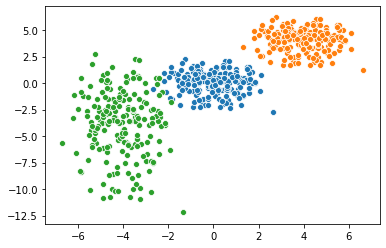

In [46]:
import seaborn as sns
sns.scatterplot(a[:,0],a[:,1])
sns.scatterplot(b[:,0],b[:,1])
sns.scatterplot(c[:,0],c[:,1])

## Q3 尝试不同λ值：4，2，10，30

In [47]:
class MeanShift:
    def __init__(self, kernel, num_init_points=None,\
                 blurring=False, threshold=0.01):
        self._kernel = kernel
        self._init_points = num_init_points
        self._blurring = blurring
        self._threshold = threshold
        self._trajectories = []
    
    def fit(self, data):
        assert len(data.shape) == 2
        if self._init_points is None:
            cluster_centres = data
        else:
            idx = np.random.randint(0,data.shape[0],self._init_points)
            cluster_centres = data[idx,:]
        while 1:
            old_centres = np.copy(cluster_centres)
            for i in range(cluster_centres.shape[0]):
                sum_num = 0
                sum_dem = 0
                for j in range(data.shape[0]):
                    kernel_val = self._kernel(cluster_centres[i,:],\
                                           data[j,:])
                    sum_num += kernel_val*data[j,:]
                    sum_dem += kernel_val
                if sum_dem != 0:
                    cluster_centres[i,:] = sum_num/sum_dem
            if (np.linalg.norm(cluster_centres-old_centres,axis=0) \
                < self._threshold).all():
                return cluster_centres
    def fit_fast(self, data):
        assert len(data.shape) == 2
        if self._init_points is None:
            cluster_centres = data
        else:
            idx = np.random.randint(0,data.shape[0],self._init_points)
            cluster_centres = data[idx,:]
        self._trajectories = [cluster_centres]
        while 1:
            old_centres = np.copy(cluster_centres)
            for i in range(cluster_centres.shape[0]):
                kernel = self._kernel(cluster_centres[i,:],\
                                           data, axis=1)
                sum_num = np.sum(np.multiply(kernel.reshape((600,1)),data),axis=0)
                sum_dem = np.sum(kernel)
                if sum_dem != 0:
                    cluster_centres[i,:] = sum_num/sum_dem
            self._trajectories.append(np.copy(cluster_centres))
            if (np.linalg.norm(cluster_centres-old_centres,axis=0) \
                < self._threshold).all():
                return cluster_centres

In [48]:
class FlatKernel:
    def __init__(self,lamda):
        self._lambda = lamda
        
    def __call__(self,x,x_i,axis=None):
        diff = x - x_i
        return (np.linalg.norm(diff, axis=axis)<self._lambda).astype(int)

In [49]:
kernel = FlatKernel(4)
MS = MeanShift(kernel, int(0.1*e.shape[0]), threshold=1e-10)

In [50]:
%%time
ccs = MS.fit(e)

Wall time: 12.2 s


In [51]:
%%time
ccs = MS.fit_fast(e)

Wall time: 94.7 ms


In [52]:
trajectories = np.array(MS._trajectories)
print(trajectories.shape)

(23, 60, 2)


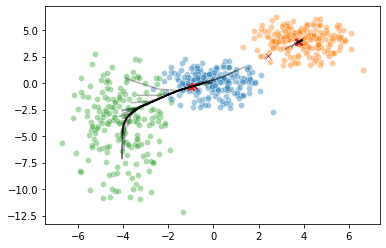

In [53]:
sns.scatterplot(a[:,0],a[:,1],alpha=0.4)
sns.scatterplot(b[:,0],b[:,1],alpha=0.4)
sns.scatterplot(c[:,0],c[:,1],alpha=0.4)
trajectories = np.array(MS._trajectories)
for i in range(trajectories.shape[1]):
    traj = trajectories[:,i,:].reshape((trajectories.shape[0],trajectories.shape[2]))
    sns.lineplot(traj[:,0],traj[:,1], color='k',alpha=0.3)
sns.scatterplot(ccs[:,0],ccs[:,1],marker='x')

In [57]:
kernel = FlatKernel(2)
MS = MeanShift(kernel, int(0.1*e.shape[0]), threshold=1e-10)

trajectories = np.array(MS._trajectories)

In [58]:
%%time
ccs = MS.fit(e)

Wall time: 11.4 s


In [59]:
%%time
ccs = MS.fit_fast(e)

Wall time: 116 ms


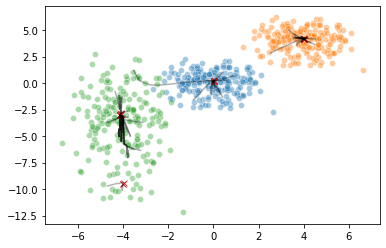

In [60]:

sns.scatterplot(a[:,0],a[:,1],alpha=0.4)
sns.scatterplot(b[:,0],b[:,1],alpha=0.4)
sns.scatterplot(c[:,0],c[:,1],alpha=0.4)
trajectories = np.array(MS._trajectories)

for i in range(trajectories.shape[1]):
    traj = trajectories[:,i,:].reshape((trajectories.shape[0],trajectories.shape[2]))
    sns.lineplot(traj[:,0],traj[:,1], color='k',alpha=0.3)
sns.scatterplot(ccs[:,0],ccs[:,1],marker='x')

In [74]:
kernel = FlatKernel(10)
MS = MeanShift(kernel, int(0.1*e.shape[0]), threshold=1e-10)

trajectories = np.array(MS._trajectories)

In [75]:
%%time
ccs = MS.fit(e)

Wall time: 2.85 s


In [76]:
%%time
ccs = MS.fit_fast(e)

Wall time: 29.9 ms


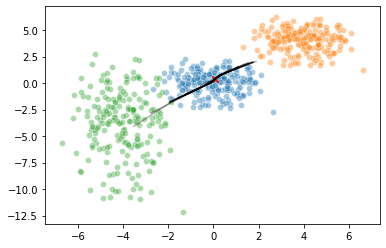

In [77]:
sns.scatterplot(a[:,0],a[:,1],alpha=0.4)
sns.scatterplot(b[:,0],b[:,1],alpha=0.4)
sns.scatterplot(c[:,0],c[:,1],alpha=0.4)
trajectories = np.array(MS._trajectories)

for i in range(trajectories.shape[1]):
    traj = trajectories[:,i,:].reshape((trajectories.shape[0],trajectories.shape[2]))
    sns.lineplot(traj[:,0],traj[:,1], color='k',alpha=0.3)
sns.scatterplot(ccs[:,0],ccs[:,1],marker='x')

In [78]:
kernel = FlatKernel(30)
MS = MeanShift(kernel, int(0.1*e.shape[0]), threshold=1e-10)

trajectories = np.array(MS._trajectories)

In [79]:
%%time
ccs = MS.fit(e)

Wall time: 868 ms


In [80]:
%%time
ccs = MS.fit_fast(e)

Wall time: 9.98 ms


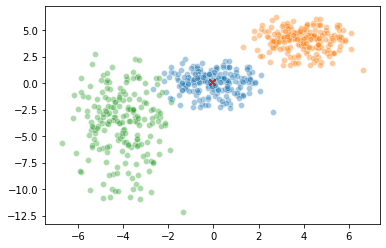

In [81]:
sns.scatterplot(a[:,0],a[:,1],alpha=0.4)
sns.scatterplot(b[:,0],b[:,1],alpha=0.4)
sns.scatterplot(c[:,0],c[:,1],alpha=0.4)
trajectories = np.array(MS._trajectories)

for i in range(trajectories.shape[1]):
    traj = trajectories[:,i,:].reshape((trajectories.shape[0],trajectories.shape[2]))
    sns.lineplot(traj[:,0],traj[:,1], color='k',alpha=0.3)
sns.scatterplot(ccs[:,0],ccs[:,1],marker='x')